In [50]:
import itertools

import pandas as pd
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn import metrics
from sklearn import linear_model

# Задача 1
Постройте модели для предсказания оценок студентов – по одной модели на каждую оценку из G1, G2 и G3.
Результаты по каждой из моделей проинтерпретируйте и сравните.
Датасет для задачи `students_regression.csv`

In [51]:
task1_file = "students_regression.csv"
task1_data = pd.read_csv(task1_file, delimiter=';')
task1_data

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2,2,services,services,...,5,5,4,4,5,4,11,9,9,9
391,MS,M,17,U,LE3,T,3,1,services,services,...,2,4,5,3,4,2,3,14,16,16
392,MS,M,21,R,GT3,T,1,1,other,other,...,5,5,3,3,3,3,3,10,8,7
393,MS,M,18,R,LE3,T,3,2,services,other,...,4,4,1,3,4,5,0,11,12,10


Логистическая и Пуассоновская регрессия не подходит для решения этой задачи. Категории с вариантами `yes`/`no` преобразуем к булину (Категорию `sex` {`F`/`M`} тоже хочется преобразовать к bool, но надо быть сильными).
Категории которые представляются набором значений стоит преобразовать используя one-hot encoding.

In [52]:
task1_data = pd.read_csv(task1_file, delimiter=';',                 # Загрузим заново
                         true_values=['yes'], false_values=['no'])  # Но с закодированными бинарными переменными
task1_data = pd.get_dummies(task1_data)  # one-hot
task1_data

,age,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,paid,activities,...,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other
0,18,4,4,2,2,0,True,False,False,False,...,False,False,True,True,False,False,False,False,True,False
1,17,1,1,1,2,0,False,True,False,False,...,True,False,False,True,False,False,False,True,False,False
2,15,1,1,1,2,3,True,False,True,False,...,True,False,False,False,False,True,False,False,True,False
3,15,4,2,1,3,0,False,True,True,True,...,False,True,False,False,True,False,False,False,True,False
4,16,3,3,1,2,0,False,True,True,False,...,True,False,False,False,True,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,20,2,2,1,2,2,False,True,True,False,...,False,True,False,True,False,False,False,False,False,True
391,17,3,1,2,1,0,False,False,False,False,...,False,True,False,True,False,False,False,False,True,False
392,21,1,1,1,1,3,False,False,False,False,...,True,False,False,True,False,False,False,False,False,True
393,18,3,2,3,1,0,False,False,False,False,...,True,False,False,True,False,False,False,False,True,False


Построим модель линейной регрессии без регуляризации

In [53]:
target_vars = ['G1', 'G2', 'G3']
predictor_vars = task1_data.columns.drop(target_vars)

# Вспомогательная функция, выписывает MSE для каждой переменной и рисует графики отклонений
def model_train_and_display(model, print_alpha: bool = False) -> None:
    for target in target_vars:
        x = task1_data[predictor_vars]
        y = task1_data[target]
        x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.3)
        model = model.fit(x_train, y_train)

        y_train_pred = model.predict(x_train)
        y_test_pred = model.predict(x_test)

        mse_train = metrics.mean_squared_error(y_train, y_train_pred)
        mse_test = metrics.mean_squared_error(y_test, y_test_pred)
        print(f"[{target}] Train MSE: {mse_train}; Test MSE: {mse_test}")

        if print_alpha:  # Для L2 и L1
            alpha = model.best_params_['alpha']
            print(f"[{target}] Best Alpha: {alpha}")

        (y_train_pred - y_train).hist(label="Train")
        (y_test_pred - y_test).hist(label="Test")
        plt.show()

[G1] Train MSE: 6.768418692160344; Test MSE: 9.988946511965839


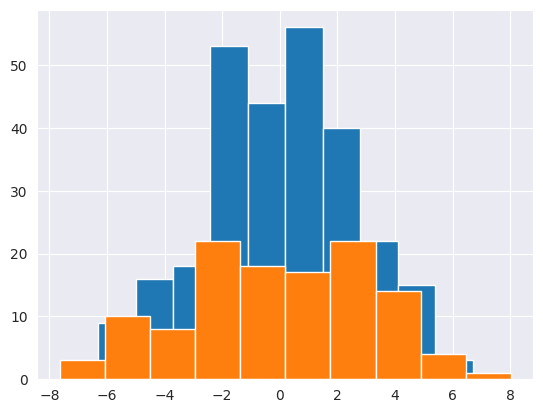

[G2] Train MSE: 9.750288203142691; Test MSE: 11.51420086772502


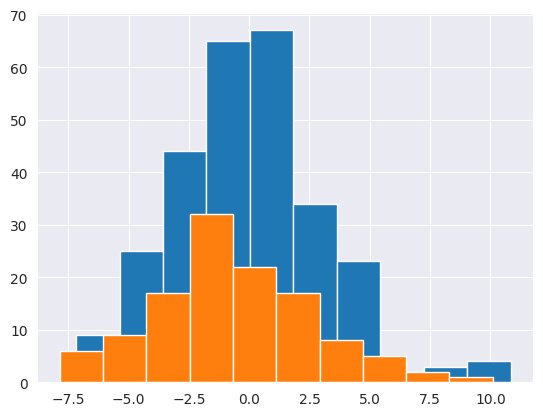

[G3] Train MSE: 15.49755328634511; Test MSE: 16.869707380022323


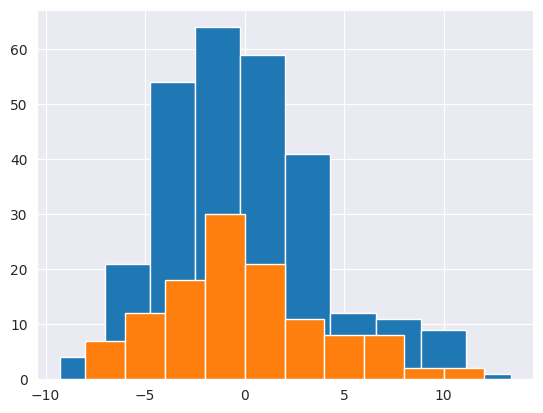

In [54]:
model_train_and_display(linear_model.LinearRegression())

Разброс небольшой и визуально похож на нормальное распределение.

Попробуем построить с L2 регуляризацией, попробуем обучить несколько моделей с разным alpha

In [55]:
possible_alphas = []
current_alpha = 0.0001
for i in range(8):
    possible_alphas += [current_alpha, current_alpha * 5]
    current_alpha *= 10

possible_alphas

[0.0001,
 0.0005,
 0.001,
 0.005,
 0.01,
 0.05,
 0.1,
 0.5,
 1.0,
 5.0,
 10.0,
 50.0,
 100.0,
 500.0,
 1000.0,
 5000.0]

[G1] Train MSE: 8.039864739061153; Test MSE: 8.335242827853023
[G1] Best Alpha: 50.0


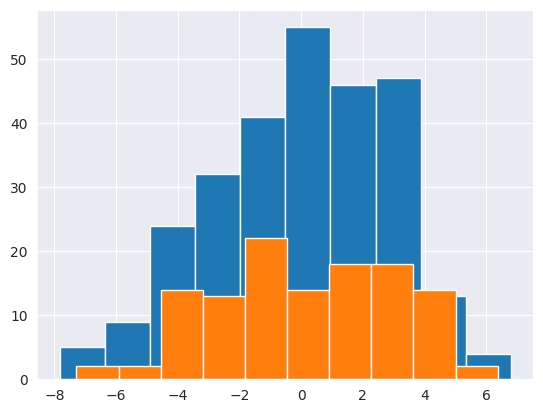

[G2] Train MSE: 9.787501403597762; Test MSE: 12.379071982682902
[G2] Best Alpha: 50.0


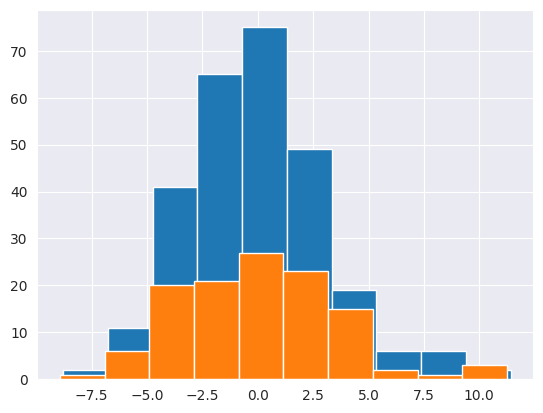

[G3] Train MSE: 14.552481864991442; Test MSE: 21.671946508849736
[G3] Best Alpha: 100.0


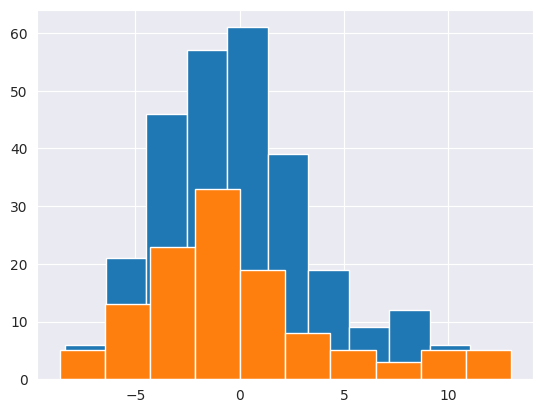

In [56]:
l2_model = linear_model.Ridge()
grid_search = model_selection.GridSearchCV(l2_model, {'alpha': possible_alphas})
model_train_and_display(grid_search, True)

Наилучшее alpha для G1, G2 = 50, для G3 = 100.
Видимое улучшение в квадратичной ошибки отсутствует.

Теперь попробуем L1 регрессию.

[G1] Train MSE: 7.653935036894657; Test MSE: 8.325723834867645
[G1] Best Alpha: 0.05


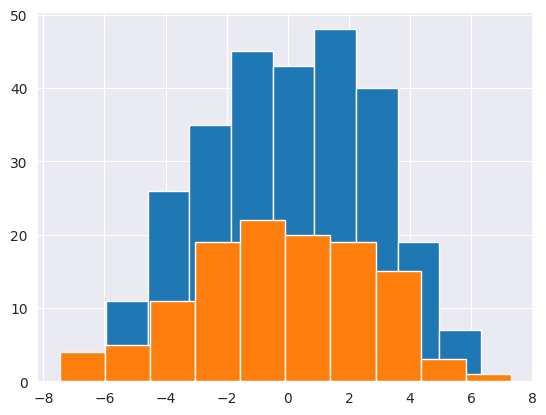

[G2] Train MSE: 10.59731465228163; Test MSE: 12.363174175398795
[G2] Best Alpha: 0.1


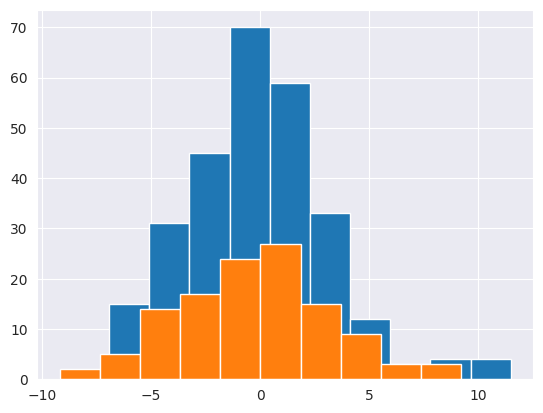

[G3] Train MSE: 18.591694938495465; Test MSE: 17.450648060664612
[G3] Best Alpha: 0.5


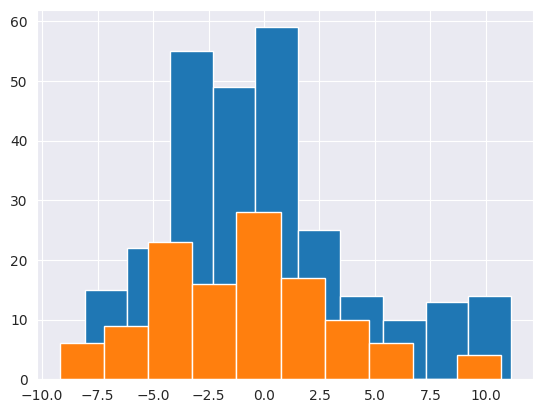

In [57]:
l2_model = linear_model.Lasso(max_iter=20000)
grid_search = model_selection.GridSearchCV(l2_model, {'alpha': possible_alphas})
model_train_and_display(grid_search, True)

Тут улучшение также отсутствует. Лучшее alpha для этой модели 0.1.

Посмотрим на самые важные параметры

In [58]:
for target in target_vars:
    x = task1_data[predictor_vars]
    y = task1_data[target]

    x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.3)
    model = linear_model.Lasso(alpha=0.1, max_iter=100000).fit(x_train, y_train)

    param_coef = sorted(zip(predictor_vars, model.coef_),
                        key=lambda pc: abs(pc[1]),  # Выберем параметры с наибольшим по модулю коэффициентом
                        reverse=True)  # По-убванию
    for param, coef in itertools.islice(param_coef, 5): # Возьмём первые 5 параметров
        print(f"[{target}] {param}: {coef}")
    print("==")

[G1] failures: -1.0680373459043857
[G1] schoolsup: -0.9457662030491131
[G1] famsup: -0.5922198621867805
[G1] Medu: 0.4691702166623014
[G1] guardian_mother: -0.41585136486992
==
[G2] failures: -1.116380977312338
[G2] famsup: -0.6236818901784698
[G2] goout: -0.4526030801218526
[G2] sex_F: -0.42890861393881907
[G2] Mjob_health: 0.41058759469785383
==
[G3] failures: -2.3116580274036953
[G3] sex_F: -0.8840637382580613
[G3] romantic: -0.8330443898601856
[G3] schoolsup: -0.8100632636844876
[G3] Mjob_services: 0.7474803387750855
==


Для всех трёх целевых переменных важен параметр `failures`, для G1 и G3 важен `schoolsup` (что бы это ни значило). Для G2 и G3 важен параметр `goout`. Все остальные параметры (из важнейших 5) не пересекаются.

# Задача 2
Постройте модель для предсказания вероятности диабета у человека на основе предоставленных признаков.
Отберите из предоставленных признаков только самые важные, основываясь на подборе наиболее подходящей по метрике f1-score модели (максимальном качестве по данной метрике).
Датасет для задачи: `diabetes_classification.csv`

In [59]:
task2_file = "diabetes_classification.csv"
task2_data = pd.read_csv(task2_file)
task2_data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


# Задача 3
Постройте модель предсказания количества претензий за период эксплуатации (ClaimNB) двигателя на основе его признаков.
Отберите только самые важные для предсказания признаки на основе результатов модели и проанализируйте результат.
Датасет для задачи: `freMTPL2freq.csv`

In [60]:
task3_file = "freMTPL2freq.csv"
task3_data = pd.read_csv(task3_file)
task3_data

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1,0.10000,D,5,0,55,50,B12,Regular,1217,R82
1,3.0,1,0.77000,D,5,0,55,50,B12,Regular,1217,R82
2,5.0,1,0.75000,B,6,2,52,50,B12,Diesel,54,R22
3,10.0,1,0.09000,B,7,0,46,50,B12,Diesel,76,R72
4,11.0,1,0.84000,B,7,0,46,50,B12,Diesel,76,R72
...,...,...,...,...,...,...,...,...,...,...,...,...
678008,6114326.0,0,0.00274,E,4,0,54,50,B12,Regular,3317,R93
678009,6114327.0,0,0.00274,E,4,0,41,95,B12,Regular,9850,R11
678010,6114328.0,0,0.00274,D,6,2,45,50,B12,Diesel,1323,R82
678011,6114329.0,0,0.00274,B,4,0,60,50,B12,Regular,95,R26
